In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from model import lorenz63

plt.style.use('seaborn')

## Nature Run (10s for spin up, 30s for nature run. dt=0.01s)

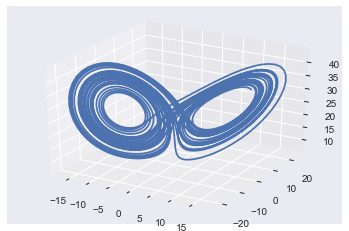

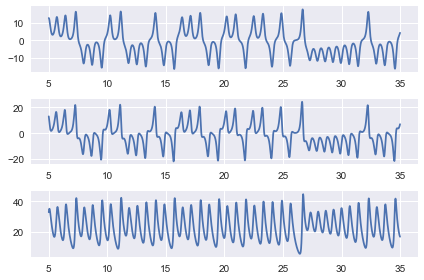

In [4]:
## X = [[x0, x1, x2, ....],
##      [y0, y1, y2, ....],
##      [z0, z1, z2, ....]]


# spin up
spinup_time = 5
dt = 0.01
X0 = np.array([[10.1], [-0.5], [40.1]])
result = lorenz63(X0.ravel(), np.arange(0, spinup_time, dt))
X_spn = result.y

# save nature run
time = 30
dt = 0.01
ts = np.arange(spinup_time, spinup_time+time, dt)
X0 = X_spn[:,[-1]]
result = lorenz63(X0.ravel(), ts)
X_nature = result.y

# plot nature run
fig1 = plt.figure()
ax1 = plt.gca(projection='3d')
ax1.plot(X_nature[0,:], X_nature[1,:], X_nature[2,:])

fig2, axs = plt.subplots(nrows=3)
axs[0].plot(ts, X_nature[0,:])
axs[1].plot(ts, X_nature[1,:])
axs[2].plot(ts, X_nature[2,:])
plt.tight_layout()

## Simulated Observation

In [7]:
def gen_random_normal(mean, var, size, random_state=None):
    """
    Generate random gaussian distribution numbers
    
    Parameters:
    ----------
    mean, var: scaler or array-like.
        If array-like, its length should equal to 'size'.
    size: int
        The amount of random numbers.
    random_state: int
        If None, np.random.randint(0, 99) will be used.
        
    Return:
    ------
    An 1d array of random numbers.
    """
    if random_state is None:
        random_state = np.random.randint(0, 99)
        
    mean = np.array(mean)
    var = np.array(var)
    
    rng = np.random.RandomState(random_state)
    result = rng.randn(max(mean.size, var.size, size))
    result = (result + mean) * np.sqrt(var)
    return result

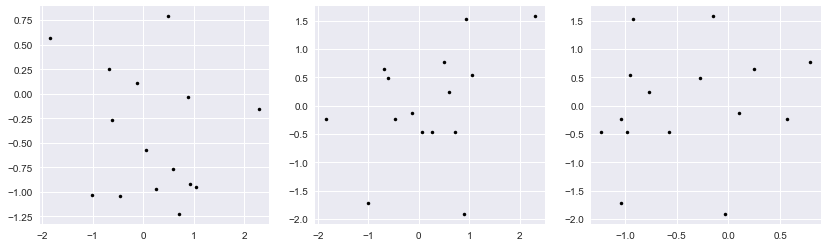

In [15]:
# observation parameters for each variables
obs_mean = [0, 0, 0]
obs_var = [1, 1, 1]
random_state = [40, 41, 42]

# assimilate observation parameters
obs_timeintv = 2
cycle_num = int(time / obs_timeintv)

# construct observation error
X_obs_err = np.zeros((3, cycle_num))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_normal(obsm, obsv, cycle_num, rst)
    
X_obs = X_nature[:,::int(obs_timeintv/dt)] + X_obs_err

# plot observation errors
fig, axs = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
axs[0].plot(X_obs_err[0], X_obs_err[1], 'k.')
axs[1].plot(X_obs_err[0], X_obs_err[2], 'k.')
axs[2].plot(X_obs_err[1], X_obs_err[2], 'k.')

## Initial condition

In [16]:
# spin up and get initial condition for experiments
# random_state=9 is very close to nature run
X0 = np.array([[10.1], [-0.5], [40.1]]) + gen_random_normal(0, 0.1, size=1, random_state=11)
result = lorenz63(X0.ravel(), np.arange(0, spinup_time, dt))
X_spn = result.y

X_ini = X_spn[:,[-1]]
X_ini

array([[13.40584987],
       [18.93082657],
       [26.77399574]])

#### (1) Test assimilation cycle: no assimilation

========Some Parameters=========
cycle length (time interval between two observations): 2 sec
number of cycle: 15
dt = 0.01 sec
initial value: [13.40584987 18.93082657 26.77399574]
initial value for nature run: [12.97960766 12.97303577 32.91253673]


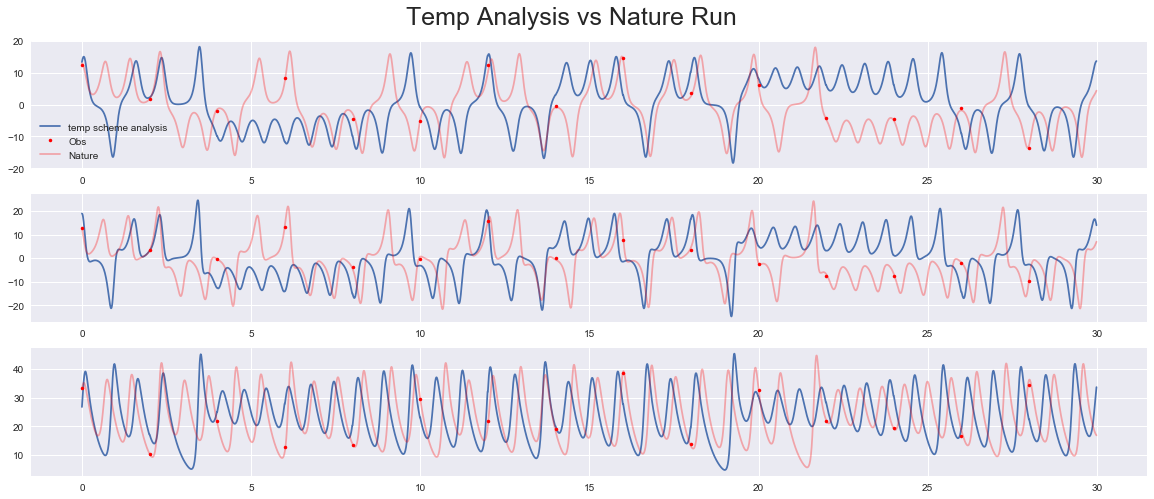

In [30]:
def temp_scheme(xb, obs, Pb, R):
    return xb, Pb


print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')


cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # calculate analysis field, then forecast
    xa = temp_scheme(xb, X_obs[:,[nc]], None, None)[0]
    x = lorenz63(xa.ravel(), ts).y
    result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
        
    # for next cycle
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)
    
    
# plot assimilation result
ts = np.arange(0, time, dt)
t_obs = np.arange(0, time, obs_timeintv)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='temp scheme analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('Temp Analysis vs Nature Run', fontsize=25, y=0.94);

#### (2.1.1) OI - NMC method using nature run as reference

In [70]:
def nmc(model, ref, dt, alpha, t1, t2, num):
    result = np.zeros((num, 2, ref[:,0].size))
    interv = int((t2-t1) / dt)
    for n in range(num):
        x0 = ref[:,n*interv]
        ts = np.arange(0, t2, dt)
        xs = model(x0, ts).y
        result[n,0,:] = xs[:,int(t1/dt)]
        result[n,1,:] = xs[:,-1]
    """    
    Pb = np.zeros((x0.size, x0.size))
    diff_t2t1 = result[:,1,:] - result[:,0,:]
    for n in range(num):
        Pb += diff_t2t1[n,np.newaxis].T * diff_t2t1[n,:]
    """
    Pb = np.zeros((x0.size, x0.size))
    for n in range(1, num):
        xf_diff = result[n,0,:] - result[n-1,1,:]
        Pb += xf_diff[:,np.newaxis] * xf_diff
        
    return alpha * Pb / num

In [74]:
R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)
Pb = nmc(lorenz63, X_nature, dt, alpha=10, t1=1, t2=2, num=20)
Pb

array([[ 2.67651328,  3.24112294, -0.63766244],
       [ 3.24112294,  5.70065579,  1.46232194],
       [-0.63766244,  1.46232194,  5.52612866]])

#### (2.1.2) OI - test NMC method by using nature run as reference

========Some Parameters=========
cycle length (time interval between two observations): 2 sec
number of cycle: 15
dt = 0.01 sec
initial value: [13.40584987 18.93082657 26.77399574]
initial value for nature run: [12.97960766 12.97303577 32.91253673]


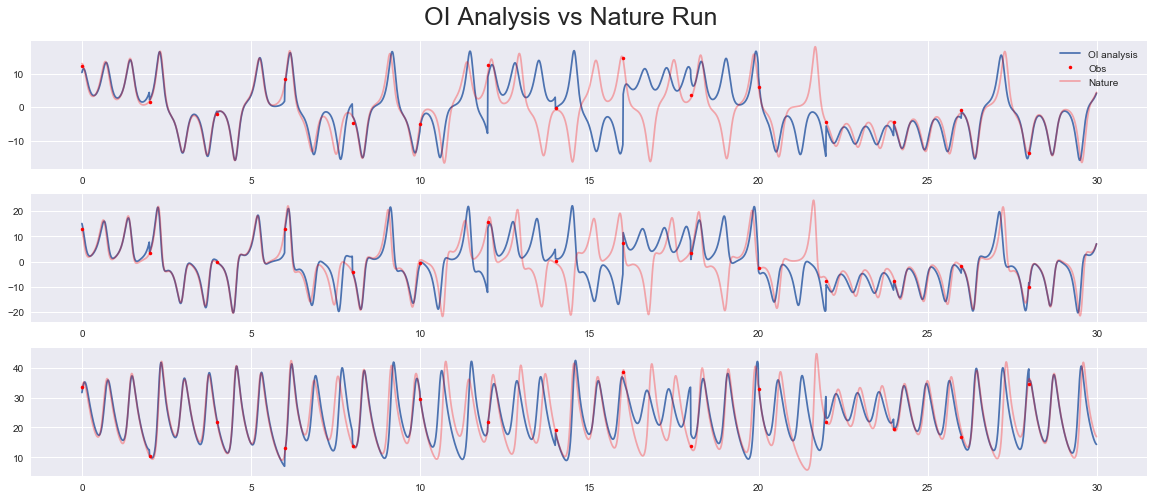

In [75]:
from assimilation_schemes import OI


print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')


cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    # calculate analysis field, then forecast
    xa = OI(xb, X_obs[:,[nc]], Pb, R)[0]
    x = lorenz63(xa.ravel(), ts).y
    result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
        
    # for next cycle
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)
    
    
# plot assimilation result
ts = np.arange(0, time, dt)
t_obs = np.arange(0, time, obs_timeintv)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='OI analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('OI Analysis vs Nature Run', fontsize=25, y=0.94);

#### (2.2.1) OI - NMC method using iterative approach

In [106]:
# observation error covariance and initial background error covariance
R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)
Pb = np.zeros((X_ini.size, X_ini.size))
np.fill_diagonal(Pb, obs_var)

# assimilation
cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

niter = 100
Pb_history = np.zeros((Pb.size, niter))
# ====== test iter =====
for i in range(niter):
    print(f'----- i = {i} -----')
    print(Pb)
    Pb_history[:,i] = Pb.ravel()
    
    # start cycle assimilation
    for nc in range(cycle_num):
        # calculate analysis field, then forecast
        xa = OI(xb, X_obs[:,[nc]], Pb, R)[0]
        x = lorenz63(xa.ravel(), ts).y
        result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x

        # for next cycle
        xb = x[:,[-1]]
        t_start = int(ts[-1] + dt)
        ts = np.arange(t_start, t_start+cycle_len, dt)

    # use `result` (assimilation result) as reference to apply NMC
    ref = result
    Pb = nmc(lorenz63, ref, dt, alpha=1, t1=1, t2=2, num=30)
    print()
print(f'----- i = {i+1} -----')
print(Pb)

----- i = 0 -----
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

----- i = 1 -----
[[47.42313039 59.28395699 -7.6348837 ]
 [59.28395699 79.47492592 -9.76829885]
 [-7.6348837  -9.76829885 15.23035533]]

----- i = 2 -----
[[81.19869293 45.8435779   9.98516596]
 [45.8435779  33.93893453 10.25809998]
 [ 9.98516596 10.25809998 59.98519813]]

----- i = 3 -----
[[58.57552812 45.25326917  8.43707441]
 [45.25326917 52.09211536 25.88721437]
 [ 8.43707441 25.88721437 34.54944353]]

----- i = 4 -----
[[23.11770183 17.23689888 -8.37366022]
 [17.23689888 26.76669123 -1.43981038]
 [-8.37366022 -1.43981038 32.82437588]]

----- i = 5 -----
[[73.70688607 49.86131616 11.59758941]
 [49.86131616 47.37477196 20.06373014]
 [11.59758941 20.06373014 34.27845847]]

----- i = 6 -----
[[47.79489978 36.56693675 -5.72431976]
 [36.56693675 39.57746786  6.56819622]
 [-5.72431976  6.56819622 45.41131912]]

----- i = 7 -----
[[63.63367009 48.53746102 -2.71354082]
 [48.53746102 55.86094739 14.76644286]
 [-2.71354082 14.76644286 

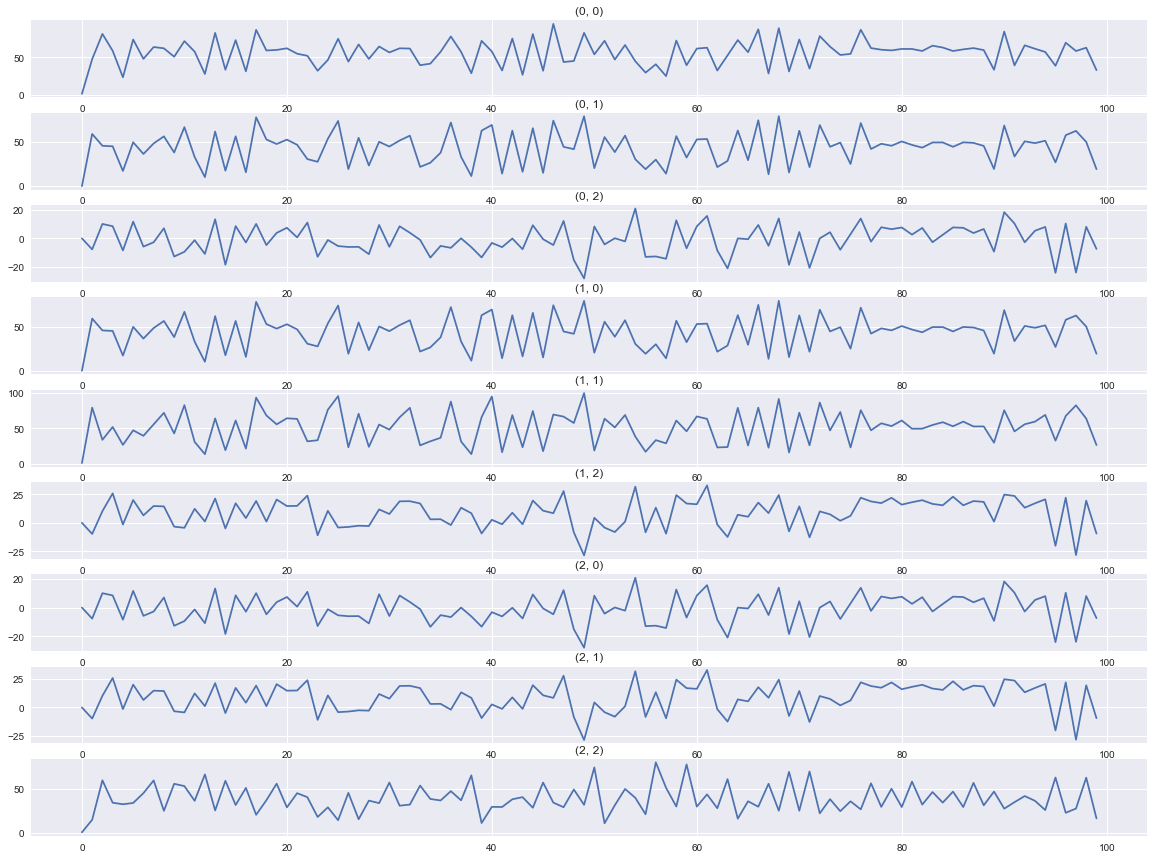

In [108]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(20, 15))
for i in range(9):
    ax[i].plot(Pb_history[i,:])
    ax[i].set_title(f'({i//3}, {i%3})')

In [114]:
Pb_history[:,int(niter/2):].mean(axis=1).reshape((3,3))

array([[56.84041412, 43.81413517,  0.52996811],
       [43.81413517, 51.73776571, 10.12985316],
       [ 0.52996811, 10.12985316, 40.50397597]])